# Experimento com duas possibilidades de treinamento de modelo visando a recuperação

Objetivo é identificar as dívidas com pontencial de recuperação, idenpendente da quantidade recuperada e não focar em identificar dívidas que serão totalmente quitadas.

- Modelagem 1: Variável target é o valor que já foi pago
- Modelagem 2: Variável target é o % da CDA que já foi pago

In [42]:
import os
import dotenv

import boto3
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
from matplotlib import pyplot as plt

import pickle
import shutil

In [43]:
import warnings
warnings.filterwarnings("ignore")

In [44]:
rootPath = os.getcwd()
dataPath = os.path.join(rootPath, 'data')
modelsPath = os.path.join(rootPath, 'models')
env = os.path.join(rootPath, '.env')
dotenv.load_dotenv(dotenv_path=env)

True

# 01) Importando dados

In [45]:
s3 = boto3.resource(
    service_name='s3',
    region_name='us-east-1',
    aws_access_key_id=os.getenv("AWS_ACESS_KEY"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACESS_KEY")
    )

def read_s3(bucket_name, folder_name, file_name):
    file_key_aws = folder_name + file_name
    obj = s3.Bucket(bucket_name).Object(file_key_aws).get()
    df = pd.read_csv(obj['Body'], sep=';')
    return df

In [46]:
dados_divida = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='feature_store_divida.csv')

dados_contribuinte = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='feature_store_contribuinte_2.csv')

In [47]:
dados_divida

,cda,id_pessoa,tipo_divida,valor_total_da,valor_pago,protesto,divida_ajuizada,ano_inscricao_da,anos_idade_da,percentual_pago_cda
0,00000123c3d4731c6b3a8e268c80aedf1,ac28642d7c82b33f,imovel,2048.73,0.00,0,0,2022,1,0.0
1,00000123c3d4731c6b3a8e268c80aedf2,fc4b99b807fbed41,mercantil,2515.85,0.00,0,0,2022,1,0.0
2,00000b44c5ba1e669ceed47545e621dd2,96e8e553de69d7a4,mercantil,1278.97,0.00,0,0,2002,21,0.0
3,000014e359592e62d8a3e5cebc255ca6E,6dbe14da38a31dc1,mercantil,847.02,0.00,0,0,2023,0,0.0
4,0000331f601a73e52b46f673bf0c61251,870c08c252b25ad1,imovel,344.12,0.00,0,0,2012,11,0.0
...,...,...,...,...,...,...,...,...,...,...
2170545,ffffd79d8aa612ac9fcacff532cf50c41,c6b16a1235d987d3,imovel,26104.42,26104.42,1,0,2022,1,1.0
2170546,ffffd8af5760cada9fcacff532cf50c41,d411f54ad97d1f39,imovel,1728.13,0.00,0,0,2019,4,0.0
2170547,ffffdb721b90282718565e26094f06ee2,51d6043a4efa1ed1,mercantil,240.77,0.00,0,0,2017,6,0.0
2170548,ffffdc78aa7a90e26b3a8e268c80aedf1,9b512f210b460120,imovel,9390.43,0.00,0,1,1998,25,0.0


# 02) Processamento da feature store

In [48]:
print("Variáveis sobre as dívidas:")
print("\n", dados_divida.columns)

Variáveis sobre as dívidas:

 Index(['cda', 'id_pessoa', 'tipo_divida', 'valor_total_da', 'valor_pago',
       'protesto', 'divida_ajuizada', 'ano_inscricao_da', 'anos_idade_da',
       'percentual_pago_cda'],
      dtype='object')


In [49]:
print("Variáveis dos constribuintes:")
print("\n", dados_contribuinte.columns)

Variáveis dos constribuintes:

 Index(['id_pessoa', 'situacao', 'cpf_cnpj_existe', 'edificacao',
       'qtd_notas_2anos', 'situacao_ativa', 'status_situacao', 'deb_totais',
       'deb_pagos', 'valor_tot', 'valor_pago', 'frequencia_da_pessoa',
       'total_debitos_pessoa', 'debitos_pagos_pessoa', 'valor_total_pessoa',
       'valor_pago_pessoa', 'historico_pagamento_em_qtd',
       'historico_pagamento_em_valor', 'class_contribuinte',
       'class_contribuinte_nome', 'class_contribuinte_peso'],
      dtype='object')


In [50]:
# Filtrando variáveis de interesse para a modelagem

df_divida = dados_divida[['cda', 'id_pessoa', 'percentual_pago_cda', 'valor_total_da', 'anos_idade_da']]
df_contribuinte = dados_contribuinte[['id_pessoa', 'frequencia_da_pessoa', 'historico_pagamento_em_qtd', 'status_situacao', 'historico_pagamento_em_valor', 'class_contribuinte_peso']]

In [51]:
df = pd.merge(left=df_divida, right=df_contribuinte, left_on='id_pessoa', right_on='id_pessoa')

In [52]:
# Filtrando apenas dados recentes para treinamento
df = df.query("anos_idade_da < 10")

In [53]:
print("Informações sobre o dataframe:\n")
df.info()

print("\nEstatísticas descritivas:")
df.describe().T

Informações sobre o dataframe:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297640 entries, 0 to 2170549
Data columns (total 10 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   cda                           1297640 non-null  object 
 1   id_pessoa                     1297640 non-null  object 
 2   percentual_pago_cda           1297640 non-null  float64
 3   valor_total_da                1297640 non-null  float64
 4   anos_idade_da                 1297640 non-null  int64  
 5   frequencia_da_pessoa          1297640 non-null  int64  
 6   historico_pagamento_em_qtd    1297640 non-null  float64
 7   status_situacao               1297640 non-null  float64
 8   historico_pagamento_em_valor  1297640 non-null  float64
 9   class_contribuinte_peso       1297640 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 108.9+ MB

Estatísticas descritivas:


,count,mean,std,min,25%,50%,75%,max
percentual_pago_cda,1297640.0,0.116074,0.320314,0.0000,0.00,0.00000,0.00000,1.000000e+00
valor_total_da,1297640.0,4850.969249,53160.015059,0.0200,788.16,1676.60000,4019.68000,2.547736e+07
anos_idade_da,1297640.0,4.941504,2.662619,0.0000,3.00,5.00000,7.00000,9.000000e+00
frequencia_da_pessoa,1297640.0,8.792136,4.746607,1.0000,5.00,9.00000,12.00000,3.700000e+01
historico_pagamento_em_qtd,1297640.0,0.115533,0.273484,0.0000,0.00,0.00000,0.00000,1.000000e+00
status_situacao,1297640.0,1.974124,1.246102,0.0000,0.00,3.00000,3.00000,3.000000e+00
historico_pagamento_em_valor,1297640.0,0.097791,0.256449,0.0000,0.00,0.00000,0.00000,1.000000e+00
class_contribuinte_peso,1297640.0,4.902833,5.675040,-1.5991,1.00,4.70957,4.70957,1.431889e+01


In [54]:
# Retirando variáveis que não serão usadas no modelo

df_feature_store = df.drop(columns=['cda', 'id_pessoa'])

In [55]:
df_feature_store.isnull().sum()

percentual_pago_cda             0
valor_total_da                  0
anos_idade_da                   0
frequencia_da_pessoa            0
historico_pagamento_em_qtd      0
status_situacao                 0
historico_pagamento_em_valor    0
class_contribuinte_peso         0
dtype: int64

In [56]:
df_feature_store.loc[df_feature_store['percentual_pago_cda'].isnull(), 'percentual_pago_cda'] = 0

In [15]:
# # Substituindo valores vazios

# df_feature_store['quantidade_reparcelamentos'] = df_feature_store['quantidade_reparcelamentos'].fillna(0)

In [57]:
df_feature_store.isnull().sum()

percentual_pago_cda             0
valor_total_da                  0
anos_idade_da                   0
frequencia_da_pessoa            0
historico_pagamento_em_qtd      0
status_situacao                 0
historico_pagamento_em_valor    0
class_contribuinte_peso         0
dtype: int64

# 03) Visualizando a variável target

In [58]:
matriz_correlacao = df_feature_store.corr()

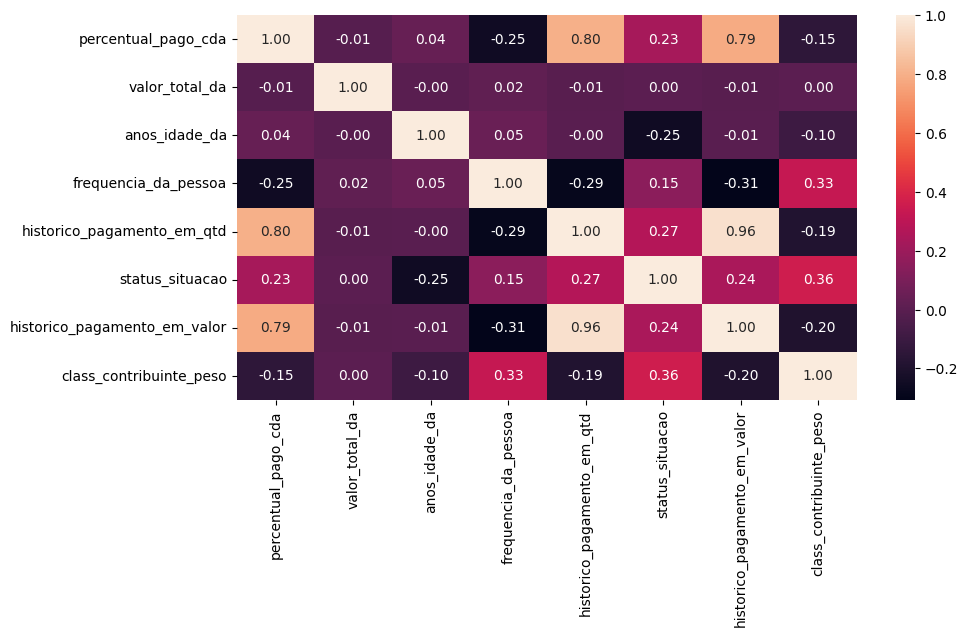

In [59]:
plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
plt.show()

# 04) Definindo pipeline de treinamento dos modelos

In [60]:
seed = 1337 # Semente fixando a aleatoridade dos experimentos

In [61]:
y = df_feature_store['percentual_pago_cda']
x = df_feature_store.drop(columns=['percentual_pago_cda'])

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=seed, test_size=0.3)

In [62]:
def roda_pipeline(algoritimo_normalizador, algoritimo_regressao, X_train, y_train, X_test, y_test):

    pipeline = Pipeline([('scaler', algoritimo_normalizador), ('regressor', algoritimo_regressao)])
    pipeline.fit(X_train, y_train)

    previsoes = pipeline.predict(X_test)

    r2 = r2_score(y_test, previsoes)
    mse = mean_squared_error(y_test, previsoes)
    
    print("\nModelo treinado:", str(algoritimo_regressao))
    print("R2 ->", r2)
    print("MSE ->", mse)

In [63]:
biblioteca_modelos = {
    'dummy': DummyRegressor(), # Dados dummy - Usado para baseline
    'random_forest': RandomForestRegressor(random_state=seed)
}

pipeline_modelos = ['dummy','random_forest']

# 05) Executando o experimento de treinamento do modelo

In [64]:
for modelos in pipeline_modelos:
    roda_pipeline(
        algoritimo_normalizador= StandardScaler(),
        algoritimo_regressao= biblioteca_modelos.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -1.7176485413994413e-06
MSE -> 0.10282638035149691

Modelo treinado: RandomForestRegressor(random_state=1337)
R2 -> 0.7996344565936552
MSE -> 0.020602828187217394


In [65]:
for modelos in pipeline_modelos:
    roda_pipeline(
        algoritimo_normalizador= MinMaxScaler(),
        algoritimo_regressao= biblioteca_modelos.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -1.7176485413994413e-06
MSE -> 0.10282638035149691

Modelo treinado: RandomForestRegressor(random_state=1337)
R2 -> 0.7991495852111045
MSE -> 0.020652685670783478


In [66]:
for modelos in pipeline_modelos:
    roda_pipeline(
        algoritimo_normalizador= RobustScaler(),
        algoritimo_regressao= biblioteca_modelos.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -1.7176485413994413e-06
MSE -> 0.10282638035149691

Modelo treinado: RandomForestRegressor(random_state=1337)
R2 -> 0.7995793717763675
MSE -> 0.02060849234986236


**Conclusão:** 
- Melhor modelo apresenta MSE menor que o Dummy
- A normalização pelo método RobustScale se provou ser a mais robusta
- O modelo apresenta pouca variáção do MSE ao acrescentar ou retirar variáveis, enquanto o R2 ajustado aumenta com a quantidade de variáveis

# 06) Realizando previsões com o melhor modelo

In [67]:
normalizador = RobustScaler()
normalizador.fit(x)
dados_normalizados = normalizador.fit_transform(x)

colunas = list(normalizador.get_feature_names_out())
df_normalizado = pd.DataFrame(dados_normalizados, columns=colunas)

In [68]:
x_norm = df_normalizado

In [69]:
X_train, X_test, y_train, y_test = train_test_split(x_norm, y, random_state=seed, test_size=0.3)

In [70]:
best_model = RandomForestRegressor(random_state=seed)
best_model.fit(X_train, y_train)

RandomForestRegressor(random_state=1337)

In [71]:
predict_test = best_model.predict(X_test)

r2 = r2_score(y_test, predict_test)
mse = mean_squared_error(y_test, predict_test)

print("Métricas de validação do modelo:")
print("R2 ->", r2)
print("MSE ->", mse)

Métricas de validação do modelo:
R2 -> 0.7995792918351613
MSE -> 0.020608500569913122


In [72]:
best_model.get_params() # Parâmetros utilizados

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1337,
 'verbose': 0,
 'warm_start': False}

In [73]:
variaveis_preditoras = best_model.feature_names_in_
importancia_variaveis = best_model.feature_importances_

print("Variáveis preditoras:")
print('\n', variaveis_preditoras)

Variáveis preditoras:

 ['valor_total_da' 'anos_idade_da' 'frequencia_da_pessoa'
 'historico_pagamento_em_qtd' 'status_situacao'
 'historico_pagamento_em_valor' 'class_contribuinte_peso']


In [74]:
dados_features = {
    'features': variaveis_preditoras,
    'importancia': importancia_variaveis
}
matriz_importancia = pd.DataFrame(dados_features).sort_values('importancia', ascending=False).reset_index(drop='index')
matriz_importancia

,features,importancia
0,historico_pagamento_em_qtd,0.698758
1,valor_total_da,0.126432
2,historico_pagamento_em_valor,0.079428
3,anos_idade_da,0.055451
4,frequencia_da_pessoa,0.032345
5,status_situacao,0.004299
6,class_contribuinte_peso,0.003286


In [75]:
# Realizando predições para avaliações do modelo

previsoes_norm = best_model.predict(x_norm)

In [76]:
# Gerando resíduos da predição (observado - previsão)
df_feature_store['y_predict'] = previsoes_norm
df_feature_store['residuos'] =  df_feature_store['percentual_pago_cda'] - df_feature_store['y_predict']

In [77]:
# chunk de check luan e larissa
df_feature_store['y_predict'].describe()

count    1.297640e+06
mean     1.160368e-01
std      2.960897e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: y_predict, dtype: float64

In [78]:
df_feature_store['percentual_pago_cda'].describe()

count    1.297640e+06
mean     1.160739e-01
std      3.203135e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: percentual_pago_cda, dtype: float64

In [79]:
def paste_intervalo(row):

    return "[" + str(row['inf']) + ", " + str(row['sup']) + ")"

data_percentil = {
    'inf': [0, 0.01, 0.25, 0.5, 0.75, 0.99, 1],
    'sup': [0.01, 0.25, 0.5, 0.75, 0.99, 1, 1.01]
}

# Creating a DataFrame from the dictionary

df_cut_percentil = pd.DataFrame(data_percentil)
df_cut_percentil['intervalo'] = df_cut_percentil.apply(paste_intervalo, axis = 1)

# Define the bins and labels for groups
igr_bins = [0, 0.01, 0.25, 0.5, 0.75, 0.99, 1, 1.01]
igr_labels = df_cut_percentil['intervalo']
 
df['percentual_pago_cda_faixas'] = pd.cut(df['percentual_pago_cda'],
                                bins = igr_bins,
                                labels = igr_labels,
                                right = False)

df_metrics = df.groupby('percentual_pago_cda_faixas')['percentual_pago_cda_faixas'].count().to_frame()
total = df_metrics['percentual_pago_cda_faixas'].sum()  
df_metrics['perc'] = df_metrics['percentual_pago_cda_faixas']/total
df_metrics

,percentual_pago_cda_faixas,perc
percentual_pago_cda_faixas,,
"[0.0, 0.01)",1147017,8.839254e-01
"[0.01, 0.25)",1,7.706298e-07
"[0.25, 0.5)",0,0.000000e+00
"[0.5, 0.75)",0,0.000000e+00
"[0.75, 0.99)",0,0.000000e+00
"[0.99, 1.0)",0,0.000000e+00
"[1.0, 1.01)",150622,1.160738e-01


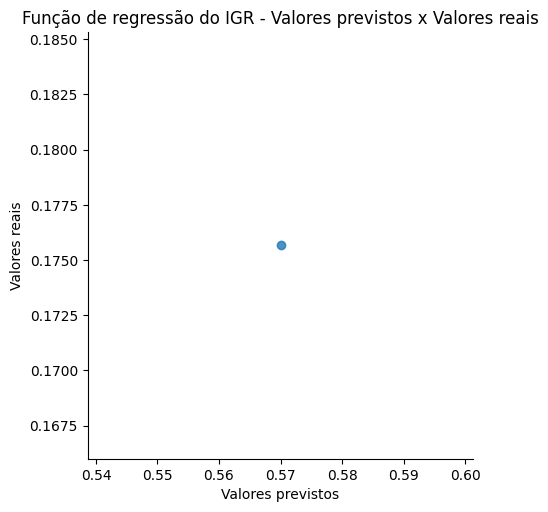

In [80]:
df_regerssao = df_feature_store.query("percentual_pago_cda != 1").query("percentual_pago_cda != 0")

sns.lmplot(x='y_predict' , y='percentual_pago_cda', data=df_regerssao)

plt.title("Função de regressão do IGR - Valores previstos x Valores reais")
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais")

plt.show()

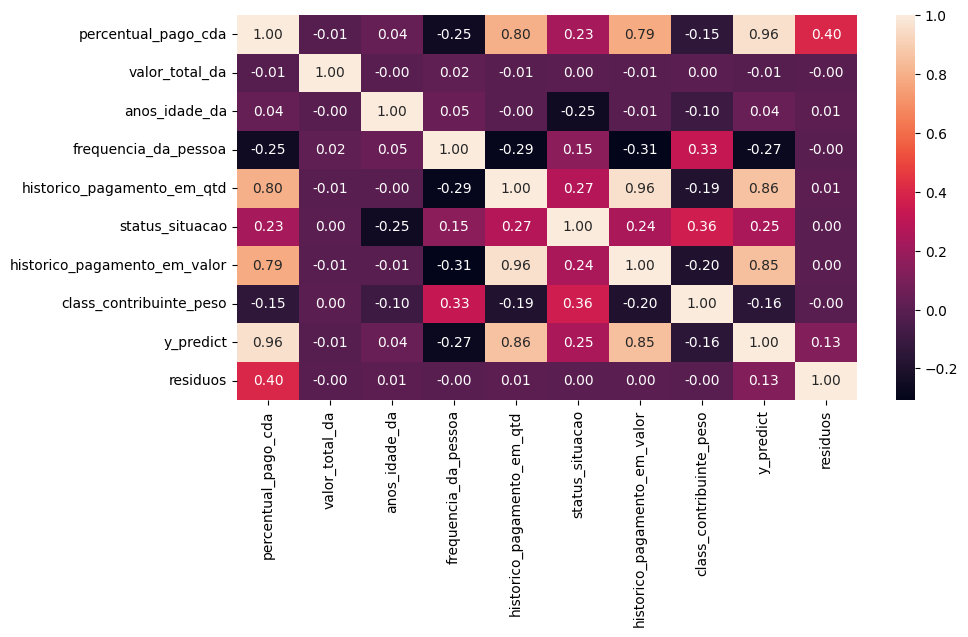

In [81]:
matriz_corr_regressao = df_feature_store.corr()
plt.figure(figsize=(10,5))
sns.heatmap(matriz_corr_regressao, annot = True, fmt = ".2f")
plt.show()

In [ ]:
sns.displot(x='residuos', data=df_feature_store)

plt.title("Histograma dos residuos")
plt.xlabel("Residuos")
plt.ylabel("Densidade")
plt.show()

# 07) Salvando o melhor modelo

In [40]:
def salva_modelo_serializado(nome_modelo_serializado, modelo):
    sav_best_model = open(nome_modelo_serializado, 'wb')
    pickle.dump(modelo, sav_best_model)
    sav_best_model.close()

    pathModelo = modelsPath+"\\"+os.path.join(nome_modelo_serializado)
    shutil.move(os.path.abspath(nome_modelo_serializado), pathModelo)

In [41]:
salva_modelo_serializado("modeloDA-igr-divida-v2.pkl", best_model)